# Using FACE to get feature attributions (Tabular Classification problem)

## Load general libraries

In [12]:
# -*- coding: utf-8 -*-

#!git clone https://github.com/CarlesBou/mlpxai.git
#!cd mlpxai/src/examples/notebooks

'''
Adjust import paths if needed
'''
import os
import sys

#print(os.getcwd())

sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.insert(0, os.path.dirname(os.getcwd()))

#sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

In [14]:
'''
Import general libraries
'''
import keras
from keras.models import Model
# from keras.utils.generic_utils import get_custom_objects

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf

import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load FACE module from mlpxai library

In [15]:
from mlpxai.explainers.face.kerasmlp import get_face_contrib # Key funtion to perform FACE feature attribution computation
from mlpxai.utils.visualize import plot_bar_contrib          # Support module to displat feature attrubution bars

## Load the dataset of a tabular classification problem

In [16]:
'''
Classfication tabular problem using 'Liver Disorder' dataset
'''

# np.seed = 1
# random.seed = 1
# tf.random.set_seed(1)
keras.utils.set_random_seed(1)

ds_name = 'liver'
dataset_name = 'Liver disorder'
liver_drinks = 7

'''
Load the Liver disorder dataset

  Attribute information:
   1. mcv	mean corpuscular volume
   2. alkphos	alkaline phosphotase
   3. sgpt	alamine aminotransferase
   4. sgot 	aspartate aminotransferase
   5. gammagt	gamma-glutamyl transpeptidase
   6. drinks	number of half-pint equivalents of alcoholic beverages
                drunk per day --> Target. Dichotimeze with
                Class 0 as drinks < 7, Class 1 with drinks >= 7
   7. selector  field used to split data into two sets --> Ignored

'''

liver_df = pd.read_csv('sample_data/liver.csv', delimiter=';')

X = liver_df.iloc[:, :-2]
y = pd.DataFrame(liver_df['drinks'])

# Dichotomize target, number of drinks per day, in two classes
y.loc[y['drinks'] < liver_drinks] = 0
y.loc[y['drinks'] >= liver_drinks] = 1

y = y.values.ravel().astype(int)

feature_names = X.columns

num_inputs = X.shape[1]
num_outputs = 2




## Define the Keras network model

In [ ]:
'''
Define the network model structure (2 hidden layers using ReLUs)
'''
input_layer = Input(shape=(num_inputs,))
hidden_layer = Dense(30, activation='relu')(input_layer)
hidden_layer = Dense(5, activation='relu')(hidden_layer)    
output_layer = Dense(num_outputs, activation='linear')(hidden_layer)

test_size = 0.15
validation_split = 0.10
epochs = 70

'''
Scale the input in range [0, 1]
'''
scaler = MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

'''
Split the dataset in train/test sets
'''
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    shuffle=True,
                                                    stratify=y)

X_test = X_test.to_numpy()

y_train_categorical = to_categorical(y_train, num_outputs).astype(np.float32)

## Create the model and compile it

In [18]:
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='nadam',
              metrics=['accuracy'],
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True))

## Train the model using the training dataset

In [19]:
print(f'Using dataset: {dataset_name}, {len(y)} samples ({len(y_train)} train / {len(y_test)} test), {num_inputs} features, {num_outputs} classes')

print('Training classification model ... ', end='')

my_fit = model.fit(X_train, y_train_categorical,
                    epochs=epochs, validation_split=validation_split, verbose=0)

print('OK')

Using dataset: Liver disorder, 341 samples (289 train / 52 test), 5 features, 2 classes
Training classification model ... OK


## Perform a model prediction over the test set to show the performance of the model

In [20]:
print('Generating predictions for test data ... ', end='')

predictions = model.predict(X_test, verbose=0)

y_mlp = np.argmax(predictions, axis=1)

print('OK')

accuracy = np.sum(y_mlp == y_test) / len(y_test)

print(f'Test data accuracy = {accuracy:.4f}\n')

Generating predictions for test data ... OK
Test data accuracy = 0.8846



## Perform the feature attribution computation using FACE

In [26]:
'''
Select a sample
'''
sample = 43

'''
We compute the feature attributions for the sample only needing
two parameters: the sample and the model to be analyzed
'''
face_contrib = get_face_contrib(X_test[sample], model)

print(f'FACE attributions for sample {sample}')
print(f'  Class 0: {face_contrib[0]}')
print(f'  Class 1: {face_contrib[1]}')

FACE attributions for sample 43
  Class 0: [ 0.95484032  0.32896234 -0.18163942 -0.05544087 -0.1640083  -0.11076466]
  Class 1: [-1.10983027 -0.4779491   0.00851536 -0.0255018   0.15161711  0.08601518]


## Display the computed attributions if a bar plot

Plotting FACE feature attributions for test sample 43, class 0


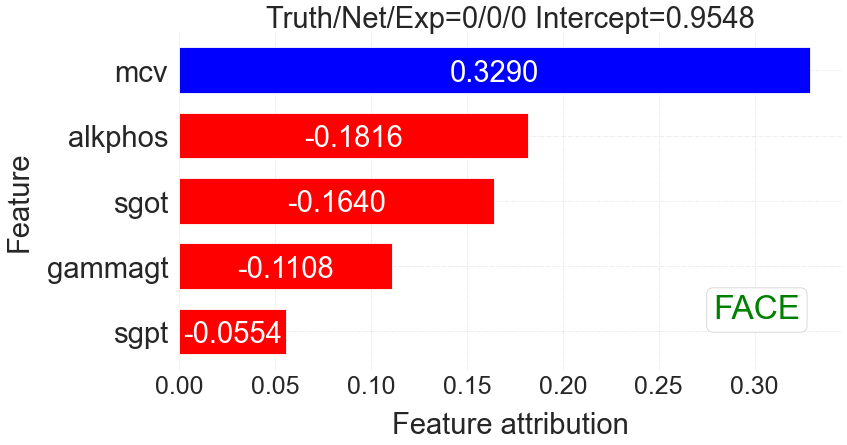

In [25]:
'''
Plot feature attributions for winning class
  - The plot title contains information about the ground truth, the network prediction, 
    and FACE's predcition (Truth/Net/Exp). It also shows the intercept.
  - Each feature is displayed with a bar and the computed attribution, shown in blue 
    for positive values and in red for negative ones.
    
'''
winning_class = np.argmax(np.sum(face_contrib, axis=1))

print(f'Plotting FACE feature attributions for test sample {sample}, class {winning_class}')

y_face = np.argmax(np.sum(face_contrib, axis=1))
    
feature_values = scaler.inverse_transform(X_test[sample].reshape(1,-1))[0]

plot_bar_contrib('classification', feature_names=feature_names, 
                contrib_class=face_contrib[winning_class],
                pred_class=y_face,
                real_class=y_test[sample],
                sample_id=sample, 
                selected_class=winning_class, 
                title=f'Truth/Net/Exp={y_test[sample]}/{y_mlp[sample]}/{y_face} Intercept={face_contrib[winning_class, 0]:.04f}',
                show_title=True,
                max_features=num_inputs,
                legend='FACE',
                add_xlabel=True,
                resize=0.6
                )